# Modelling the UKs reponse to coronavirus

ID: 660030047

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Importing Data**

The following cell imports and creates the graph that will be used in the simulation.

In [0]:
G = nx.read_edgelist('data/facebook_combined.txt')
print('Graph loaded succesfully.')
print('Nodes:', len(G.nodes))
print('Edges:', len(G.edges))

Graph loaded succesfully.
Nodes: 4039
Edges: 88234


**The Model**

The cells below provide the functions for the simulation. This includes the simulation iteslf, processing data and plotting that data.

In [0]:
def simulation(G, days, rI, rS, rQ, rR, rD, lockdownStart, lockdownEnd, reducedRI):
  '''
  This is a simulation of the spread of COVID-19
  over a graph, with slowdown measures that have
  been implemented by the UK government.

  States are recorded in the state array. They 
  are categorised as follows:

  Index : State
  0 : Susceptible
  1 : Infected - Symptomatic
  2 : Infected - Asymptomatic
  3 : Infected - Quarantined
  4 : Recovered
  5 : Dead

  Arguments:
    G: Input Graph
    days: Number of days simulation runs for

    rI: Probability of infection
    rS: Probability of having symptoms
    rQ: Probability of being quarantined
    rR: Probability of recovering
    rD: Probability of dying

    lockdownStart: Day to start lockdown.
    lockdownEnd: Day to end lockdown.
    reducedRI: Value for rI to be changed to.

  Returns:
    Numpy array containing records of how many
    people in each state for every time iteration.
  '''

  # Random seed to replicate results.
  np.random.seed(0)
  
  # Generate adjacency matrix of graph to optimise code.
  adj = nx.to_numpy_matrix(G)
  N = len(adj)

  # Array to store state of each person.
  state = np.zeros(N)
  nStates = 6

  # Infect certain number of population to start simulation.
  initialInfections = 3
  infect = np.random.randint(N, size=initialInfections)
  state[infect] = 1

  # Array to store results.
  output = []
  statusCount = [np.count_nonzero(state == i) for i in range(nStates)]
  output.append([0] + statusCount)

  for t in range(1, days):

    # Lockdown feature
    if lockdownStart == t:
      rIOriginal = rI
      rI = reducedRI

    if lockdownEnd == t:
      rI = rIOriginal
    
    # Susceptible.
    for n in np.where(state == 0)[0]:
      incomingIdxs = adj[n].nonzero()[1]
      incomingInfected = np.count_nonzero((state[incomingIdxs] == 1) | (state[incomingIdxs] == 2))
      infection = np.random.rand(incomingInfected) < rI
      infected = np.any(infection)
      symptoms = np.random.rand() < rS

      if infected:
        state[n] = 1 if symptoms else 2

    # Infected - Symptomatic.
    infected = np.where(state == 1)[0]
    quarantine = np.random.rand(len(infected)) < rQ
    quarantineIdxs = infected[quarantine]
    state[quarantineIdxs] = 3

    # Infected - Symptomatic, Asymptomatic and Quanantined.
    infected = np.where((state == 1) | (state == 2) | (state == 3))[0]
    recovery = np.random.rand(len(infected)) < rR
    recovered = infected[recovery]
    state[recovered] = 4

    # Recovered.
    death = np.random.rand(len(recovered)) < rD
    dying = recovered[death]
    state[dying] = 5

    # Record values of each state.
    statusCount = [np.count_nonzero(state == i) for i in range(nStates)]
    output.append([t] + statusCount)

  return np.array(output)



def processResults(results):
  '''
  Input results and groups based on state.
  Returns domain, susceptible, infected, recovered, deaths.
  '''
  
  X = results[:,0]

  S = results[:,1]
  I = results[:,2] + results[:,3] + results[:,4]
  R = results[:,5]
  D = results[:,6]

  return X, S, I, R, D

def printResults(results):
  '''
  Ouputs key features from the results.
  '''

  X, S, I, R, D = results

  # Find number of nodes.
  n = sum([x[0] for x in results])

  print('Final values:')
  print()
  print('Remaining Susceptible: {:.2f}%'.format(S[-1] * 100 / n))
  print('Total Infected: {:.2f}%'.format((D[-1] + R[-1] + I[-1]) * 100 / n))
  print('Peak Infected: {:.2f}%'.format(max(I) * 100 / n))
  print('Total Deaths: {:.2f}%'.format(D[-1] * 100 / n))
  print()



def plotResults(results):
  '''
  Takes results from a simulation and outputs
  general states plot and seperate deaths plot.
  '''

  X, S, I, R, D = results
  
  # Figure size for two graphs.
  plt.figure(figsize=(8, 4))

  # Graph 1
  plt.subplot(1, 2, 1)
  plt.plot(X, S)
  plt.plot(X, I)
  plt.plot(X, R)
  plt.plot(X, D)

  plt.title('Infection Model over Time')
  plt.xlabel('Time')
  plt.ylabel('People')
  plt.legend(['Susceptible', 'Infected', 'Recovered', 'Dead'])

  # Graph 2
  plt.subplot(1, 2, 2)
  plt.plot(X, D)

  plt.title('Deaths over Time')
  plt.xlabel('Time')
  plt.ylabel('People')

  plt.show()


def experiment(G=G, days = 100, rI = 0.02, rS = 1, rQ = 0, rR = 0.05, rD = 0.01,
               lockdownStart=None, lockdownEnd=None, reducedRI=0):
  '''
  Calls required functions to simulate model then display data.
  '''

  results = simulation(G, days, rI, rS, rQ, rR, rD, lockdownStart, lockdownEnd, reducedRI)
  results = processResults(results)
  printResults(results)
  plotResults(results)

**Results**

The following cells show the results from the experiments using different parameter values. Explanation of these results will be discussed in the report.

The meaning of some parameters is listed below.



*    rI: Probability of infection
*    rS: Probability of having symptoms
*    rQ: Probability of being quarantined
*    rR: Probability of recovering
*    rD: Probability of dying



1. SIR Model

The following simulation has used parameters that represent the basic SIR model. That is all people show symptoms and none are placed into quarantine. The one difference is that I have include the chance to die instead of recovering. The results are consistent with what we would expect using the regular SIR model. This is a good test for the algorithm as it provides confidence that it is working.

Final values:

Remaining Susceptible: 7.77%
Total Infected: 92.23%
Peak Infected: 46.47%
Total Deaths: 0.97%



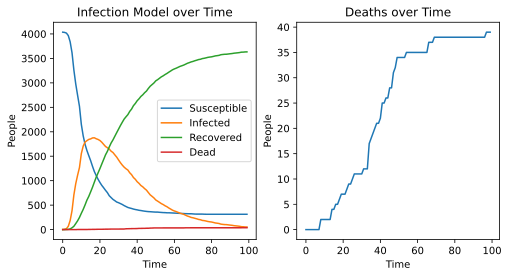

In [0]:
experiment()

2. Social Distancing

* Simple social distancing measures will reduce the infection rate.
* rI reduced by half from 0.02 to 0.01

Final values:

Remaining Susceptible: 29.88%
Total Infected: 70.12%
Peak Infected: 31.94%
Total Deaths: 0.79%



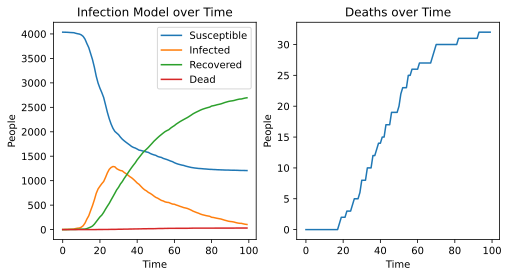

In [0]:
experiment(rI=0.01)

3. Self-Isolation

* Government advised people who experience symptoms to self isolate.
* This model assumes all people experience symptoms.
* rQ set to 0.2

Final values:

Remaining Susceptible: 52.93%
Total Infected: 47.07%
Peak Infected: 31.12%
Total Deaths: 0.37%



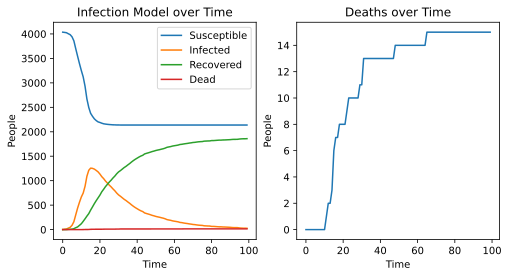

In [0]:
experiment(rS = 1, rQ = 0.3)

4. Testing

* Data is unclear however CDC estimated 25% of infected are asymptomatic. [Link.](https://www.npr.org/sections/health-shots/2020/03/31/824155179/cdc-director-on-models-for-the-months-to-come-this-virus-is-going-to-be-with-us)
* rS set to 0.75, cocntinuing with rQ of 0.3.

Final values:

Remaining Susceptible: 32.51%
Total Infected: 67.49%
Peak Infected: 35.55%
Total Deaths: 0.64%



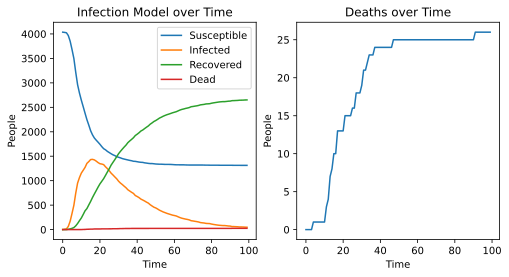

In [0]:
experiment(rS = 0.75, rQ = 0.3)

5. Lockdown

* Government imposed nationwide lockdown.

Final values:

Remaining Susceptible: 14.71%
Total Infected: 85.29%
Peak Infected: 30.35%
Total Deaths: 0.89%



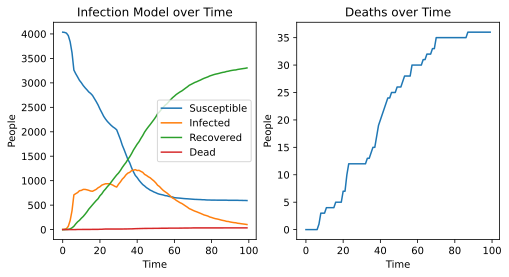

In [0]:
experiment(lockdownStart=7, lockdownEnd=30, reducedRI=0.005)

Final values:

Remaining Susceptible: 20.92%
Total Infected: 79.08%
Peak Infected: 23.22%
Total Deaths: 0.82%



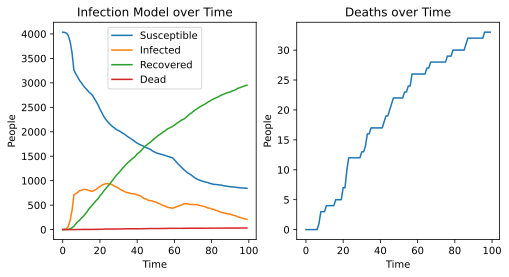

In [0]:
experiment(lockdownStart=7, lockdownEnd=60, reducedRI=0.005)

5. Combination

* This simulation uses combination of all values in order to see their combined effect.


Final values:

Remaining Susceptible: 67.15%
Total Infected: 32.85%
Peak Infected: 9.98%
Total Deaths: 0.25%



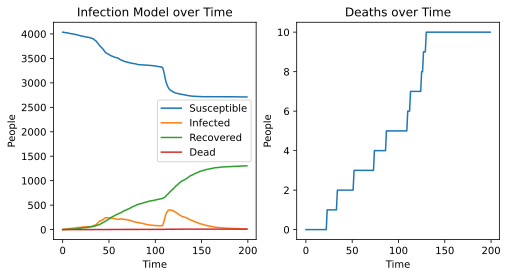

In [0]:
experiment(days=200, rI = 0.01, rS = 0.75, rQ = 0.3, lockdownStart=7, lockdownEnd=60, reducedRI=0.005)